# Testing Inactives

In [99]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

from itertools import chain

from local_utils.rdkit_utils import FP

import seaborn as sns

In [29]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [30]:
sns.set()

## Reload  data

### Load actives

In [31]:
actives, active_mols = pd.read_pickle('actives.pkl')

actives.shape[0], actives['symbol'].unique().size, actives['usmiles'].unique().size, active_mols.shape[0]

(167055, 138, 104749, 104749)

In [32]:
# actives.head(1)

,symbol,usmiles
symbol,,
ABCB1,ABCB1,C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12


,mol,FP,core_smiles
usmiles,,,
C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12,,"[0 0 0 ..., 0 0 0]",O=c1cc(-c2ccccc2)oc2ccccc12

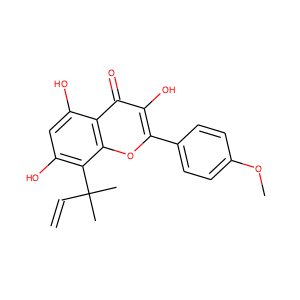

In [33]:
# active_mols.head(1)

### Load inactives

In [59]:
inactives, inactive_mols = pickle.load(open('inactives.pkl'))

inactives.shape, inactive_mols.shape

((81966, 2), (35377, 4))

In [61]:
# inactives.head(1)

In [60]:
# inactive_mols.head(1)

## Re-train classifier on all actives

### Reformat and add mols

In [62]:
train = actives.groupby('usmiles').apply(lambda x: x['symbol'].tolist()).to_frame('symbols')\
         .merge(active_mols[['FP']], left_index=True, right_index=True)\
         .reset_index(drop=False)
        
train.shape

(104749, 3)

In [65]:
# train.head(1)

In [64]:
# Fit model using full set...

X = [x.fp for x in train['FP']]

y = train['symbols'].tolist()

classifier = OneVsRestClassifier(MultinomialNB())

classifier.fit(X, y)

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=1)

### Predict inactives

In [40]:
# Predict activities of 'inactives' set...

X = [x.fp for x in inactive_mols['FP']]

predictions = classifier.predict(X)

len(predictions)

35377

In [86]:
# Known inactive USMILES, by symbol...

known_by_sym = inactives[['symbol', 'usmiles']].groupby('symbol').apply(lambda x: set(x['usmiles'])).to_frame('usmiles')

# Predicted active USMILES, by symbol...

pred_by_sym = pd.concat(pd.DataFrame({'usmiles': x, 'symbol': y}) for x, y in zip(inactive_mols['usmiles'], predictions)).groupby('symbol').apply(lambda x: set(x['usmiles'])).to_frame('usmiles')

known_by_sym.shape, pred_by_sym.shape

((138, 1), (138, 1))

In [87]:
tmp = known_by_sym.merge(pred_by_sym, left_index=True, right_index=True, suffixes=('_known', '_pred'))

def f(x):
    
    x['n_known'] = len(x['usmiles_known'])
    
    x['n_overlap'] = len(x['usmiles_known'].intersection(x['usmiles_pred']))
    
    x['wrong'] = x['n_overlap'] / x['n_known']
    
    return x
    
inactives_pred = tmp.apply(f, axis=1).drop(['usmiles_known', 'usmiles_pred'], axis=1).sort('wrong', ascending=False).reset_index(drop=False)

inactives_pred.shape

(138, 4)

In [88]:
inactives_pred.head(1)

,symbol,n_known,n_overlap,wrong
0,UTS2R,14,14,1


In [89]:
# Add counts of actives for comparison...

inactives_pred = inactives_pred.merge(actives.groupby('symbol')['usmiles'].count().to_frame('n_active'), left_on='symbol', right_index=True)

In [90]:
inactives_pred.head(1)

,symbol,n_known,n_overlap,wrong,n_active
0,UTS2R,14,14,1,167


In [91]:
# Add summary of actives...

summary = pd.read_pickle('summary.pkl').merge(inactives_pred, on='symbol')

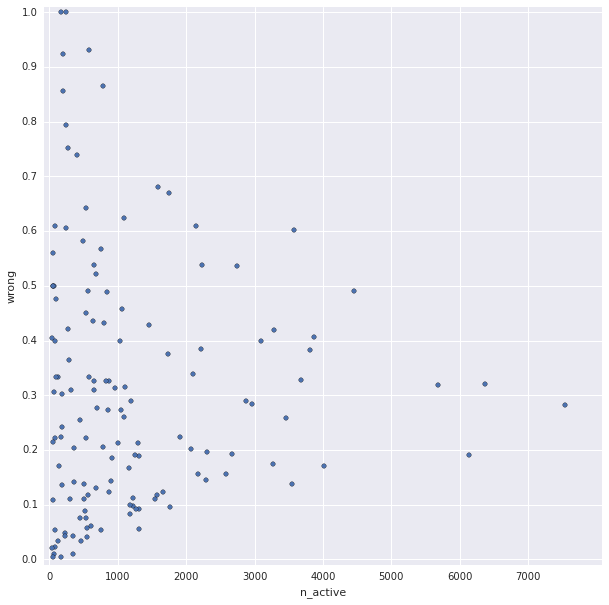

In [92]:
summary.plot(x='n_active', y='wrong', kind='scatter', xlim=(-80, 8080), xticks=np.arange(0, 8000, 1000), ylim=(-0.01, 1.01), yticks=np.arange(0, 1.1, 0.1), figsize=(10, 10))

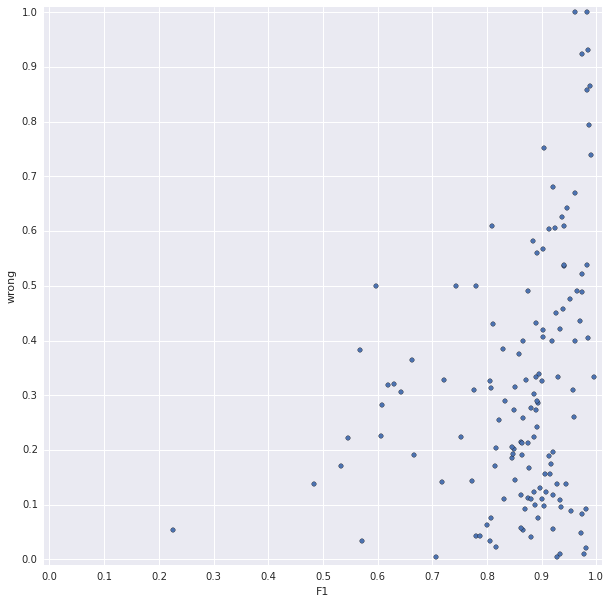

In [95]:
summary.plot(x='F1', y='wrong', kind='scatter', xlim=(-0.01, 1.01), xticks=np.arange(0, 1.1, 0.1), ylim=(-0.01, 1.01), yticks=np.arange(0, 1.1, 0.1), figsize=(10, 10))

In [97]:
def get_color_map(n_classes):

    n = int(round(n_classes/2))*2 # Round up to next even number for convenience
        
    color_map = plt.get_cmap('gist_rainbow')(np.linspace(0.0, 1.0, n))

    return color_map[list(chain.from_iterable(zip(range(0, int(n/2)), range(int(n/2), n))))[:n_classes]] # Return number requested

In [100]:
# Colour mapping...

classes = sorted(summary['target_class'].unique().tolist())

class_numbers = [classes.index(x) for x in summary['target_class']]

color_map = get_color_map(len(classes))

color = [color_map[x] for x in class_numbers]

# Get subset of points for a target class...

def get_points(i, x):
    
    df = summary.query("target_class == @x")
    
    return axis.scatter(x=df[xcol], y=df[ycol], color=color_map[i], s=75)

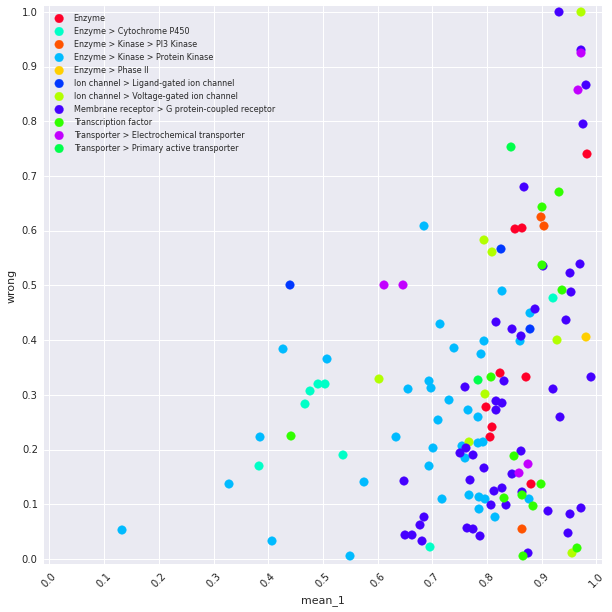

In [104]:
# Plot...

xcol, ycol = 'mean_1', 'wrong'
                                                         
fig, axis = plt.subplots(1, 1, figsize=(10, 10))
    
points = [get_points(i, x) for i, x in enumerate(classes)]

xticks = np.arange(0, 1.1, 0.1)
axis.set_xlim(-0.01, 1.01)
axis.set_xticks(xticks)
axis.set_xticklabels(xticks, rotation=45)
axis.set_xlabel(xcol)

yticks = np.arange(0, 1.1, 0.1)
axis.set_ylim(-0.01, 1.01)
axis.set_yticks(yticks)
axis.set_yticklabels(yticks)
axis.set_ylabel(ycol)

axis.legend(points, classes, scatterpoints=1, loc='upper left', fontsize=8)

None

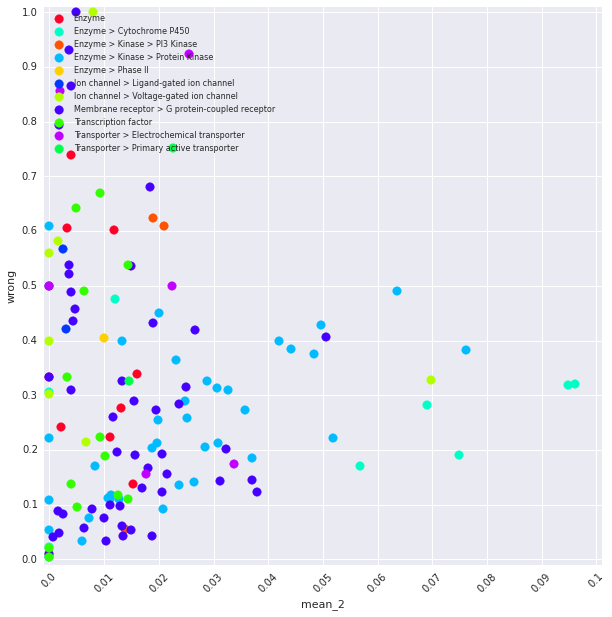

In [106]:
# Plot...

xcol, ycol = 'mean_2', 'wrong'
                                                         
fig, axis = plt.subplots(1, 1, figsize=(10, 10))
    
points = [get_points(i, x) for i, x in enumerate(classes)]

xticks = np.arange(0, 0.11, 0.01)
axis.set_xlim(-0.001, 0.101)
axis.set_xticks(xticks)
axis.set_xticklabels(xticks, rotation=45)
axis.set_xlabel(xcol)

yticks = np.arange(0, 1.1, 0.1)
axis.set_ylim(-0.01, 1.01)
axis.set_yticks(yticks)
axis.set_yticklabels(yticks)
axis.set_ylabel(ycol)

axis.legend(points, classes, scatterpoints=1, loc='upper left', fontsize=8)

None

In [103]:
summary.sort('wrong', ascending=False).head(10)

,symbol,mean_1,sd_1,mean_2,sd_2,N,target_class,F1,n_known,n_overlap,wrong,n_active
136,UTS2R,0.9309,0.043119,0.0048,0.009600,42,Membrane receptor > G protein-coupled receptor,0.961379,14,14,1.000000,167
35,CACNA1G,0.9726,0.026196,0.0080,0.010733,62,Ion channel > Voltage-gated ion channel,0.981935,40,40,1.000000,247
97,MTNR1B,0.9724,0.013551,0.0035,0.003500,145,Membrane receptor > G protein-coupled receptor,0.984247,29,27,0.931034,580
130,SLC29A1,0.9725,0.024989,0.0256,0.012371,51,Transporter > Electrochemical transporter,0.973380,53,49,0.924528,202
59,EDNRB,0.9810,0.008000,0.0040,0.004359,198,Membrane receptor > G protein-coupled receptor,0.988283,372,322,0.865591,789
129,SLC10A2,0.9666,0.021565,0.0020,0.006000,51,Transporter > Electrochemical transporter,0.981958,28,24,0.857143,202
95,MLNR,0.9750,0.013274,0.0017,0.005100,60,Membrane receptor > G protein-coupled receptor,0.986469,34,27,0.794118,237
1,ABCG2,0.8435,0.035018,0.0225,0.020402,67,Transporter > Primary active transporter,0.903716,113,85,0.752212,266
3,ACE,0.9830,0.012689,0.0040,0.006633,100,Enzyme,0.989401,169,125,0.739645,398
7,ADORA2B,0.8682,0.019482,0.0183,0.007484,396,Membrane receptor > G protein-coupled receptor,0.920380,747,508,0.680054,1584
